In [1]:
%matplotlib inline
import time
import praw
import pprint
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
from collections import OrderedDict

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
# This function plots a word cloud for a given string. Shows the top n_words most repeated words in a phrase. 
# It uses the package wordcloud. For more info: goto https://github.com/amueller/word_cloud 
def my_word_cloud(text="This is a sample wordcloud phrase", n_words=5, plot_title=""):
    import numpy as np
    from PIL import Image
    from os import path
    import matplotlib.pyplot as plt
    import random
    from wordcloud import WordCloud, STOPWORDS

    stopwords = set(STOPWORDS)
    stopwords.add("OC")
    stopwords.add("oc")
    stopwords.add("serious")
    
    wc = WordCloud(max_words=n_words, margin=25, stopwords=stopwords, random_state=1).generate(text)
    
    # store default colored image
    default_colors = wc.to_array()
    plt.figure(figsize=(10,10))
    plt.title(plot_title, fontsize=16)
    plt.imshow(default_colors)
    plt.axis("off")
    fname = plot_title.replace('/r/','')
    fname = fname + '.pdf'
    plt.savefig(fname)
    plt.show()

In [4]:
def import_stop_words(filename="FrequentWords.csv"):

    df = pd.read_csv(filename)
    stopwords = df['Word'].tolist()
    stopwords = [x.lower() for x in stopwords]
    stopwords.append("reddit")
    stopwords.append("serious")
    stopwords.append("makes")
    stopwords.append("make")
    stopwords.append("wants")
    stopwords.append("want")
    stopwords.append("needs")
    stopwords.append("need")
    
    return (stopwords)

In [5]:
def word_cloud_subreddit(timeframe='day', subreddit_name='dataisbeautiful', query_type='title', max_post_count=100):
    
    r = praw.Reddit('Clinton- related-question monitor by momo')
    subreddit = r.get_subreddit(subreddit_name)

    max_post_count = 100 

    if (timeframe == 'hour'):
        submissions = subreddit.get_top_from_hour(limit= max_post_count)
    elif (timeframe == 'day'):
        submissions = subreddit.get_top_from_day(limit= max_post_count)
    elif (timeframe == 'week'):
        submissions = subreddit.get_top_from_week(limit= max_post_count)
    elif (timeframe == 'month'):
        submissions = subreddit.get_top_from_month(limit= max_post_count)
    elif (timeframe == 'year'):
        submissions = subreddit.get_top_from_year(limit= max_post_count)
    elif (timeframe == 'all'):
        submissions = subreddit.get_top_from_all(limit= max_post_count)
        
    stopwords = import_stop_words("FrequentWords.csv")
    result = ""
    title_text = ""
    for submission in submissions:
#        print(submission.title, submission.is_self)
        if query_type == 'title':
            querywords = submission.title
        elif query_type == 'body':
            if (submission.is_self):
                querywords = submission.selftext() # Problematic. Seems like it has issues when the body text has url in it
            else:
                continue
        querywords = querywords.replace('(', ' ')
        querywords = querywords.replace(')', ' ')
        querywords = querywords.replace(',', ' ')
        querywords = querywords.replace('.', ' ')
        querywords = querywords.replace('!', ' ')
        querywords = querywords.replace('?', ' ')
        querywords = querywords.replace('-', ' ')
        querywords = querywords.replace('"', ' ')
#        querywords = querywords.replace('\'', ' ')
        querywords = querywords.replace('\\', ' ')
        querywords = querywords.replace('/', ' ')
        querywords = querywords.replace(':', ' ')
        querywords = querywords.replace(';', ' ')
        querywords = querywords.replace('*', ' ')
        querywords = querywords.replace('*', ' ')
        querywords = querywords.replace('  ', ' ')
        querywords = querywords.lower()
        
        querywords = querywords.split(' ')
        resultwords  = [word for word in querywords if word not in stopwords]
        result = ' '.join(resultwords)
        title_text += result
    return(title_text)


In [6]:
def text_length_vs_score(timeframe='day', subreddit_name='dataisbeautiful', query_type='title', max_post_count=100):
    
    r = praw.Reddit('Clinton- related-question monitor by momo')
    subreddit = r.get_subreddit(subreddit_name)

    max_post_count = 100 

    if (timeframe == 'hour'):
        submissions = subreddit.get_top_from_hour(limit= max_post_count)
    elif (timeframe == 'day'):
        submissions = subreddit.get_top_from_day(limit= max_post_count)
    elif (timeframe == 'week'):
        submissions = subreddit.get_top_from_week(limit= max_post_count)
    elif (timeframe == 'month'):
        submissions = subreddit.get_top_from_month(limit= max_post_count)
    elif (timeframe == 'year'):
        submissions = subreddit.get_top_from_year(limit= max_post_count)
    elif (timeframe == 'all'):
        submissions = subreddit.get_top_from_all(limit= max_post_count)
    
    text_length = []
    scores = []
    for submission in submissions:
        if query_type == 'title':
            querywords = submission.title
            
        elif query_type == 'body':
            if (submission.is_self):
                querywords = submission.selftext() # Problematic. Seems like it has issues when the body text has url in it
            else:
                continue
        text_length.append(len(querywords))
        scores.append(submission.score)
    return text_length, scores

In [10]:
def compare_top_posts_title_length(subreddit_names):

    counter = 0

    fig = plt.figure(figsize=(14,14))
    for titles, names in subreddit_names.iteritems():
        length, scores = text_length_vs_score(timeframe='all', subreddit_name=names, query_type='title', max_post_count=200)
        counter += 1
        ax = plt.subplot(3,3,counter)
        ax.plot(scores, length, 'ro')
        mean_length = [np.mean(length) for i in scores]
        ax.plot(scores, mean_length, 'b--')
        title_ = titles + " (/r/"+ names + ")"
        ax.set_title(title_, fontsize=14)
        ax.set_xlabel('Reddit Score')
        ax.set_ylabel('Character Count')
        ax.set_ylim([10,300])
        #ax.set_xlim([1000,10000])
        #ax.figure.autofmt_xdate()
        
    # Save the figure 
    fig.tight_layout()
    plt.savefig('ComparisonTitleLength.png', bbox_inches='tight')
    plt.savefig('ComparisonTitleLength.pdf', bbox_inches='tight')
    plt.show()

In [11]:
subreddit_names = OrderedDict([('Technology','technology'),('Science','science'), ('SpaceX','spacex'),
                                   ('Personal Finance','Personalfinance'), ('Legal Advice','legaladvice'),
                                   ('Startups','startups'), ('Art','art'), ('Food','food'), 
                                   ('Comics','comics')])

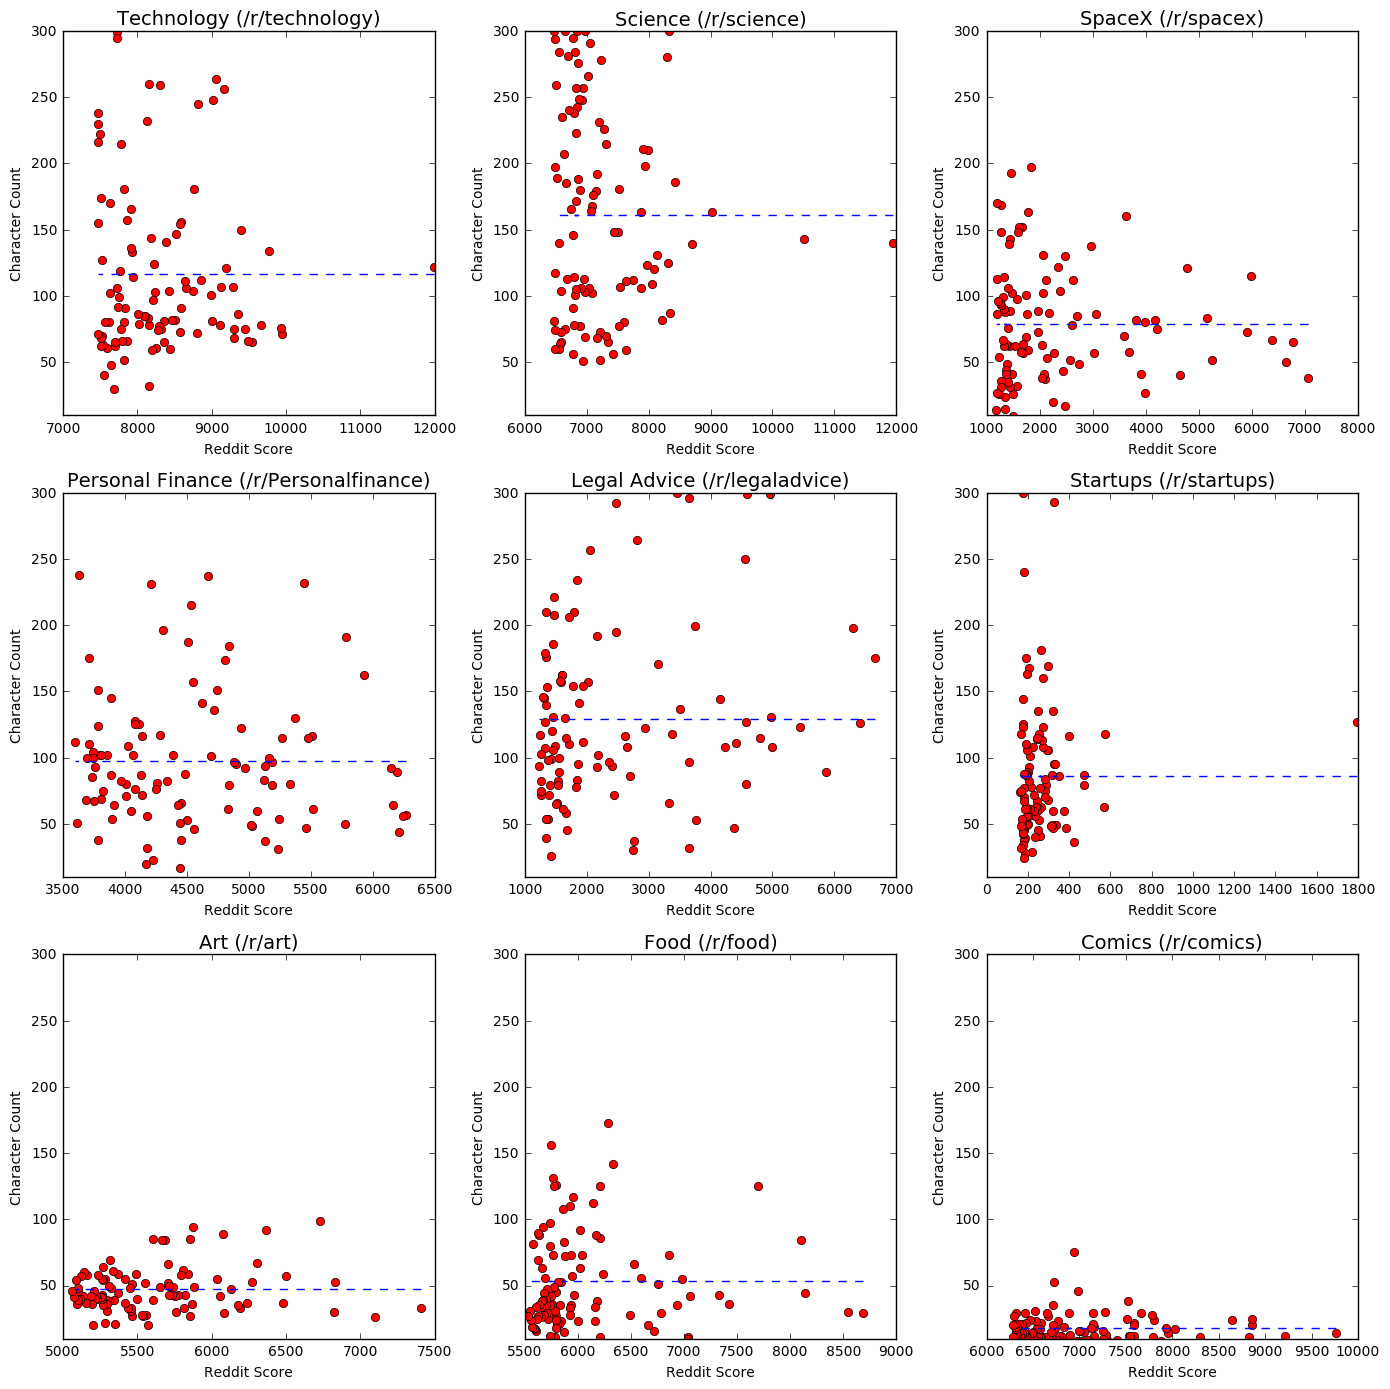

In [12]:
compare_top_posts_title_length(subreddit_names)

In [13]:
def plot_word_cloud_subreddits(subreddit_names):

    counter = 0
    for titles, names in subreddit_names.iteritems():
        cloud_text = word_cloud_subreddit(timeframe='all', subreddit_name=names, query_type='title', max_post_count=200)
        title_ = "/r/"+names
        my_word_cloud(text=cloud_text, n_words=10, plot_title=title_)
        counter += 1

In [14]:
subreddit_names = OrderedDict([('Technology','technology'), ('Personal Finance','personalfinance'), ('Food', 'food'), ('Data is Beautiful', 'dataisbeautiful')])

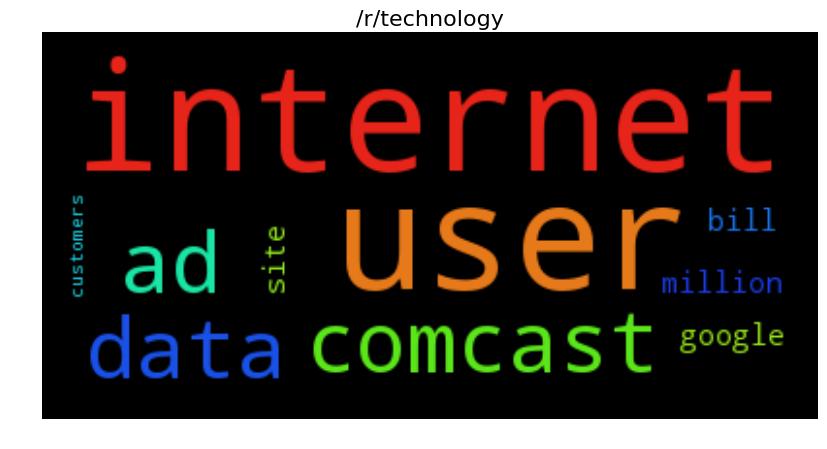

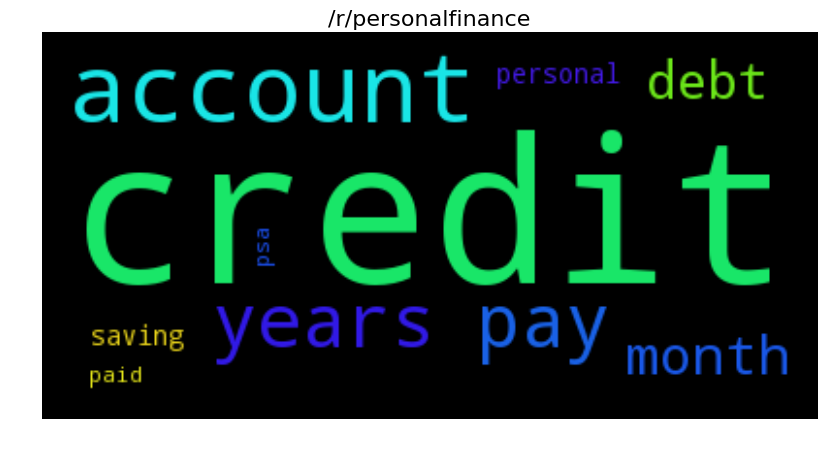

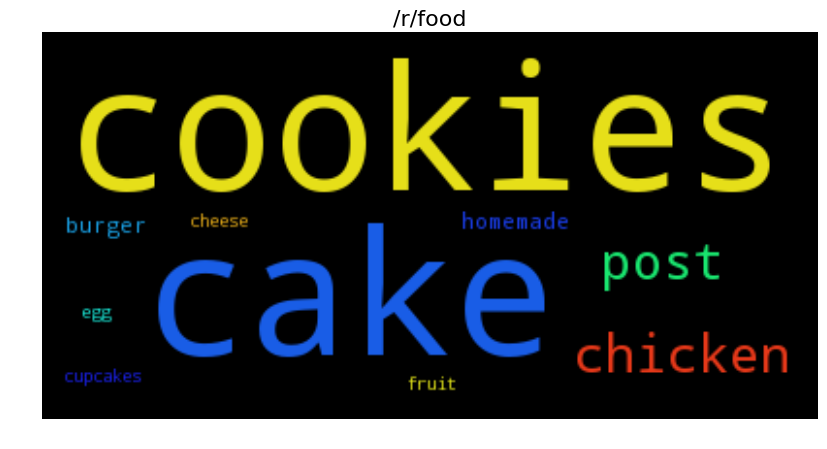

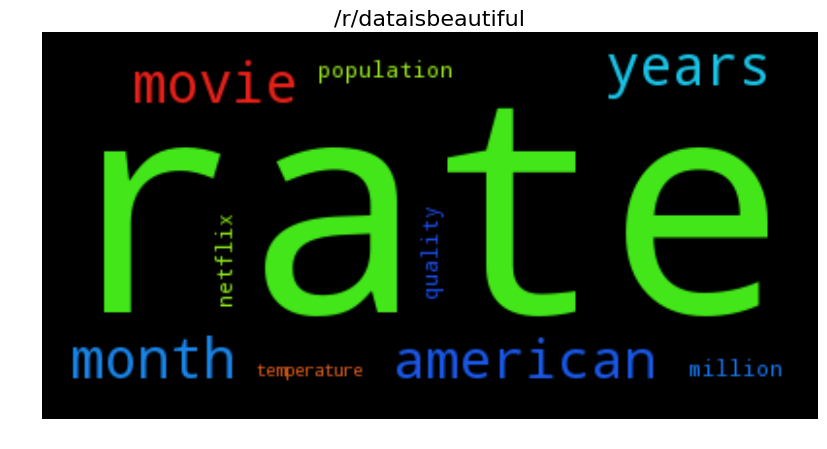

In [15]:
plot_word_cloud_subreddits(subreddit_names)